In [1]:
from keras.models import model_from_json
import keras
from keras.optimizers import Adam
import numpy as np
import copy
import matplotlib.pyplot as plt
np.random.seed(0)
import pandas as pd
import ast
import os

from calculate_metrics import *

Using TensorFlow backend.


In [2]:
# Load model
with open("model.json") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load weights
loaded_model.load_weights("model_weights.h5")
print("Model has been loaded")

Model has been loaded


In [3]:
loaded_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

## Load the data

In [4]:
rescale_bool = True
# Load the data
print("Loading the data ...\n\n")
if rescale_bool:
    images = np.load("cropped_rescaled_images.npy")
    images_gt = np.load("cropped_rescaled_images_gt.npy")
else:
    images = np.load("cropped_images.npy")
    images_gt = np.load("cropped_images_gt.npy")

print("Image data has size: {}".format(images.shape))
print("Ground truth has size: {}".format(images_gt.shape))

# For now keep only the labels of the Left Venctricle (removes RV, myocardium)
images_gt[images_gt != 3] = 0
images_gt[images_gt == 3] = 1

# Scale data and convert to 4D (requirement: for the conv2d training)
images = images / np.amax(images) # scale
images = np.reshape(images, newshape=(*images.shape, 1))
images_gt = np.reshape(images_gt, newshape=(*images_gt.shape, 1))

print("Reshaped image data has size: {}".format(images.shape))
print("Reshaped ground truth has size: {}\n\n".format(images_gt.shape))

# Load patient information
patient_info = pd.read_csv("patient_info.csv", converters={"spacing": ast.literal_eval,"image_pixels": ast.literal_eval }) # the converter is used to convert back the tuple

id_list = patient_info["patient_id"].to_numpy()
image_sizes = patient_info["image_pixels"].to_numpy()
image_sizes = np.array([*image_sizes])
z_dim = image_sizes[:,2]

# Create an array of (1902,) where each row corresponds to the ID of every slice
# of the dataset
patient_id_array = np.array([])
for patient_id in id_list:
    patient_id_array = np.append(patient_id_array, np.full(shape=2*z_dim[patient_id-1], fill_value=patient_id))

print("The array of patient IDs has shape: ", patient_id_array.shape)

# Split dataset to train/valid/test based on patient ids (doesnt mix patient slices)
# First split the ids
np.random.seed(0) # seed for reproducability
np.random.shuffle(id_list)
train_ids = id_list[:70] # 70% - 15% - 15% split
valid_ids = id_list[70:85]
test_ids = id_list[85:]

# Sort the split IDs (this is the order they are masked)
train_ids = copy.deepcopy(np.sort(train_ids))
valid_ids = copy.deepcopy(np.sort(valid_ids))
test_ids = copy.deepcopy(np.sort(test_ids))

# Create the id masks
train_msk = np.isin(patient_id_array, train_ids)
valid_msk = np.isin(patient_id_array, valid_ids)
test_msk = np.isin(patient_id_array, test_ids)

print("The train set consists of {} slices".format(np.count_nonzero(train_msk)))
print("The validation set consists of {} slices".format(np.count_nonzero(valid_msk)))
print("The test set consists of {} slices".format(np.count_nonzero(test_msk)))

# Now split the images based on the masks
train_set = images[train_msk]
train_set_gt = images_gt[train_msk]

valid_set = images[valid_msk]
valid_set_gt = images_gt[valid_msk]

test_set = images[test_msk]
test_set_gt = images_gt[test_msk]

Loading the data ...


Image data has size: (1902, 128, 128)
Ground truth has size: (1902, 128, 128)
Reshaped image data has size: (1902, 128, 128, 1)
Reshaped ground truth has size: (1902, 128, 128, 1)


The array of patient IDs has shape:  (1902,)
The train set consists of 1334 slices
The validation set consists of 298 slices
The test set consists of 270 slices


## Predict for validation

In [5]:
###### Uncomment to save prediction for the validation #########
if not(os.path.exists("prediction_scaled_crop.npy")):
    prediction = loaded_model.predict(valid_set, batch_size=64, verbose=1)
    np.save("prediction_scaled_crop", prediction)

In [6]:
prediction = np.load("prediction_scaled_crop.npy")
prediction /= np.amax(prediction)
prediction = prediction[:,:,:,0]
print(prediction.shape)
print(np.amax(prediction))

valid_set = valid_set[:,:,:,0]
valid_set_gt = valid_set_gt[:,:,:,0]
valid_id_array = patient_id_array[valid_msk]

(298, 128, 128)
1.0


In [7]:
index_start = 0
dice_scores = []
for patient_id in valid_ids:
    index_end = index_start + 2*z_dim[patient_id-1]
    opt_seg, opt_threshold, opt_dice = optimal_treshold(valid_set_gt[index_start:index_end], prediction[index_start:index_end])
#     print(index_start, index_end)
    index_start = index_end
    print("Patient {} \tDice score: {} \tOptimal threshold: {}".format(patient_id, opt_dice, opt_threshold))
    dice_scores.append(opt_dice)
    
mean_dice_score = np.mean(dice_scores)
print("\nMean dice score with threshold = {} (Validation Set)".format(mean_dice_score))

Patient 20 	Dice score: 0.7692241304910675 	Optimal threshold: 0.99
Patient 21 	Dice score: 0.9266583526337668 	Optimal threshold: 0.999595
Patient 26 	Dice score: 0.8762649779598932 	Optimal threshold: 0.99
Patient 30 	Dice score: 0.8929922809141819 	Optimal threshold: 0.997777
Patient 38 	Dice score: 0.9187682686425124 	Optimal threshold: 0.99
Patient 40 	Dice score: 0.928055664959958 	Optimal threshold: 0.991717
Patient 47 	Dice score: 0.7559926244622004 	Optimal threshold: 0.99
Patient 50 	Dice score: 0.9358048162230672 	Optimal threshold: 0.99
Patient 70 	Dice score: 0.9258997882851094 	Optimal threshold: 0.997676
Patient 73 	Dice score: 0.8443432042520881 	Optimal threshold: 0.9997969999999999
Patient 78 	Dice score: 0.948072272015934 	Optimal threshold: 0.9991909999999999
Patient 82 	Dice score: 0.9136681335749418 	Optimal threshold: 0.999999
Patient 95 	Dice score: 0.9291591072106662 	Optimal threshold: 0.990404
Patient 98 	Dice score: 0.9212924606462303 	Optimal threshold: 0.9

## Predict for training set

In [8]:
# Predict and save
if not(os.path.exists("prediction_scaled_crop_train.npy")):
    prediction_train = loaded_model.predict(train_set, batch_size=64, verbose=1)
    np.save("prediction_scaled_crop_train", prediction_train)

In [9]:
prediction_train = np.load("prediction_scaled_crop_train.npy")

prediction_train /= np.amax(prediction_train)
prediction_train = prediction_train[:,:,:,0]

train_set = train_set[:,:,:,0]
train_set_gt  = train_set_gt[:,:,:,0]

In [10]:
index_start = 0
dice_scores = []

for patient_id in train_ids:
    index_end = index_start + 2*z_dim[patient_id-1]
    opt_seg, opt_threshold, opt_dice = optimal_treshold(train_set_gt[index_start:index_end], prediction_train[index_start:index_end])
#     print(index_start, index_end)
    index_start = index_end
    print("(Train) Patient {} \tDice score: {} \tOptimal threshold: {}".format(patient_id, opt_dice, opt_threshold))
    dice_scores.append(opt_dice)

mean_dice_score_training = np.mean(dice_scores)
print("\nMean dice score with threshold = {} (Training Set)".format(mean_dice_score_training))

(Train) Patient 1 	Dice score: 0.9722973915469382 	Optimal threshold: 0.9990899999999999
(Train) Patient 2 	Dice score: 0.9664041661374317 	Optimal threshold: 0.993434
(Train) Patient 3 	Dice score: 0.9693470560343626 	Optimal threshold: 0.990202
(Train) Patient 4 	Dice score: 0.9587178522868632 	Optimal threshold: 0.999898
(Train) Patient 5 	Dice score: 0.9649963770135443 	Optimal threshold: 0.9953529999999999
(Train) Patient 6 	Dice score: 0.9441375903722664 	Optimal threshold: 0.9996959999999999
(Train) Patient 7 	Dice score: 0.9689964245481706 	Optimal threshold: 0.9990899999999999
(Train) Patient 8 	Dice score: 0.9583853968598902 	Optimal threshold: 0.9991909999999999
(Train) Patient 9 	Dice score: 0.9752189194019182 	Optimal threshold: 0.990303
(Train) Patient 11 	Dice score: 0.9717389183388078 	Optimal threshold: 0.998888
(Train) Patient 12 	Dice score: 0.9773070288917637 	Optimal threshold: 0.9996959999999999
(Train) Patient 14 	Dice score: 0.9753269009554664 	Optimal threshold

# Unthresholded performance

## Validation set

In [11]:
# Validation set
unthresholded_prediction = copy.deepcopy(prediction)
unthresholded_prediction[unthresholded_prediction<1] = 0

dice_scores = []
index_start = 0
for patient_id in valid_ids:
    index_end = index_start + 2*z_dim[patient_id-1]
    unthresholded_dice = dice_score(valid_set_gt[index_start:index_end], unthresholded_prediction[index_start:index_end])
    index_start = index_end
    print("Patient {} \tDice score: {} \t (without threshold)".format(patient_id, unthresholded_dice))
    dice_scores.append(unthresholded_dice)

mean_dice_score_validation_unthresholded = np.mean(dice_scores)
print("\nMean dice score without threshold = {} (Validation Set)".format(mean_dice_score_validation_unthresholded))

Patient 20 	Dice score: 0.7678471051152332 	 (without threshold)
Patient 21 	Dice score: 0.9265946074355624 	 (without threshold)
Patient 26 	Dice score: 0.8760803332711559 	 (without threshold)
Patient 30 	Dice score: 0.8929274572164168 	 (without threshold)
Patient 38 	Dice score: 0.9186062338369403 	 (without threshold)
Patient 40 	Dice score: 0.9276372001314492 	 (without threshold)
Patient 47 	Dice score: 0.754817024096956 	 (without threshold)
Patient 50 	Dice score: 0.9356576862123613 	 (without threshold)
Patient 70 	Dice score: 0.9257734384190095 	 (without threshold)
Patient 73 	Dice score: 0.8443432042520881 	 (without threshold)
Patient 78 	Dice score: 0.9480673464548257 	 (without threshold)
Patient 82 	Dice score: 0.9136681335749418 	 (without threshold)
Patient 95 	Dice score: 0.928348119983101 	 (without threshold)
Patient 98 	Dice score: 0.9210990150336962 	 (without threshold)
Patient 99 	Dice score: 0.8960847081999508 	 (without threshold)

Mean dice score without th

## Training set

In [12]:
# Training set
unthresholded_prediction_train = copy.deepcopy(prediction_train)
unthresholded_prediction_train[unthresholded_prediction_train<1] = 0

dice_scores = []
index_start = 0
for patient_id in train_ids:
    index_end = index_start + 2*z_dim[patient_id-1]
    unthresholded_dice_train = dice_score(train_set_gt[index_start:index_end], unthresholded_prediction_train[index_start:index_end])
    index_start = index_end
    print("(Train) Patient {} \tDice score: {} (without threshold)".format(patient_id, unthresholded_dice_train))
    dice_scores.append(unthresholded_dice_train)
    
mean_dice_score_training_unthresholded = np.mean(dice_scores)
print("\nMean dice score without threshold = {} (Training Set)".format(mean_dice_score_training_unthresholded))

(Train) Patient 1 	Dice score: 0.9722973915469382 (without threshold)
(Train) Patient 2 	Dice score: 0.9663892242200902 (without threshold)
(Train) Patient 3 	Dice score: 0.9691573394367377 (without threshold)
(Train) Patient 4 	Dice score: 0.9586877278250304 (without threshold)
(Train) Patient 5 	Dice score: 0.9648980957426047 (without threshold)
(Train) Patient 6 	Dice score: 0.9441375903722664 (without threshold)
(Train) Patient 7 	Dice score: 0.9689681353939602 (without threshold)
(Train) Patient 8 	Dice score: 0.9583853968598902 (without threshold)
(Train) Patient 9 	Dice score: 0.9749336830496855 (without threshold)
(Train) Patient 11 	Dice score: 0.9717389183388078 (without threshold)
(Train) Patient 12 	Dice score: 0.977251900167107 (without threshold)
(Train) Patient 14 	Dice score: 0.9751685578029929 (without threshold)
(Train) Patient 15 	Dice score: 0.959059893858984 (without threshold)
(Train) Patient 16 	Dice score: 0.9764074294999692 (without threshold)
(Train) Patient 1

# ROC Analysis

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [19]:
# ROC analysis
fpr, tpr, thresolds = roc_curve(valid_set_gt.flatten(), prediction.flatten())

# Calculate AUC
auc = roc_auc_score(valid_set_gt.flatten(), prediction.flatten())

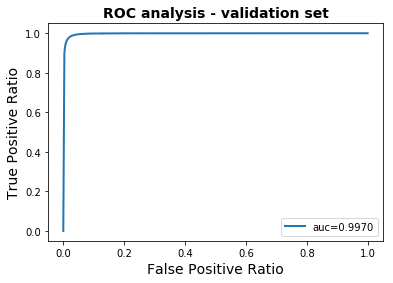

In [22]:
plt.plot(fpr, tpr, linewidth=2, label=f"auc={auc:.4f}")
plt.title("ROC analysis - validation set", fontsize=14, fontweight="bold")
plt.xlabel("False Positive Ratio", fontsize=14)
plt.ylabel("True Positive Ratio", fontsize=14)
plt.legend()
plt.show()